# [nlp] Transformer : Attention is All You Need 논문 분석 및 코드 실습


> 2021/03/30 Happy-jihye 🌺
> 
> **Reference** : [pytorch-seq2seq/6 - Attention is All You Need](https://github.com/bentrevett/pytorch-seq2seq)
> 
> **paper** : [Attention is All You Need(2017)](https://arxiv.org/abs/1706.03762)

--- 

# 0. Introduction

- 오늘 소개해드릴 모델은 드디어 **Transformer**입니다. Transformer는 Google에서 2017년에 발표한 모델로, 최근까지 NLP에서 가장 많이 사용되는 architecture이며 이를 기반으로 한 연구들이 지금까지도 *state-of-the-art*한 결과를 내고 있습니다. 

  현재 NLP에서 가장 인기있는 모델은 Google의 [BERT](https://arxiv.org/abs/1810.04805)(Bidirectional Encoder Representations from Transformers)나 OpenAI의 [GPT-3](https://arxiv.org/abs/2005.14165)로, 이 역시 transformer의 architecure를 사용하고 있습니다. 이 모델들에 대해서는 향후 포스팅 하겠습니다 :)

- 기존의 번역 모델들은 RNN을 활용한 Encoder-Decoder의 구조였다면, Transformer부터는 논문의 제목([Attention is All You Need(2017)](https://arxiv.org/abs/1706.03762)) 처럼 오직 Attention만을 사용하여 자연어를 처리합니다. 

---
  

RNN 모델들은 language modeling이나 machine translation과 같은 sequence modeling에서 자주 사용되었습니다. 

다만, Recurrent model은 순차적으로 연산을 하기 때문에 parallelization이 어려웠고, 문장이 길어질 수록 성능 역시 떨어지며, memory의 제약으로 batch에도 제한이 생길 수 있다는 문제점이 있었습니다. (`factorization tricks`이나 `conditional computation`등의 방법을 통해 어느정도 연산에 있어서 efficiency를 높이긴 했지만, Sequential computation의 근본적인 문제를 해결하지는 못했습니다.)


따라서 이 문제를 해결하기 위해 나온 모델이 바로 Transformer입니다. 이 논문에서는 CNN이나 RNN 모델 없이 오직 Attention mechanism만을 사용하여 machine translation task를 진행하였고, 이는 매우 좋은 성능을 내게 됩니다 !!




# 1. Paper Review

## Model Architecture

<p align="center"><img src="https://github.com/happy-jihye/Natural-Language-Processing/blob/main/images/transformer1.png?raw=1" width = "400" ></p>

Transformer는 Encoder-Decoder 모델을 따르며, 주요 architecture로는 **stacked self-attention, point-wise fully connected layers**를 사용합니다.

### Encoder

- Encoder는 모두 N개의 동일한 layer가 반복되는 형태입니다.(논문에서의 N = 6)
- 위의 그림에서도 볼 수 있다시피 Encoder layer는 **Multi-head Self-Attention mechanism**과 **Positional-wise fully connected Feed-Forward network**의 2개의 layer로 구성됩니다.  
- 또한, 두개의 sub-layer에 **residual connection** 방식을 적용하여 성능을 높였으며, 이 계산을 쉽게하기 위해서 embedding layer와 2개의 sub-layer의 output의 dimension을 512로 맞춰주었습니다.


### Decoder

- Decoder도 Encoder와 마찬가지로 N = 6개의 layer를 반복하여 사용했습니다.
- Decoder는 3개의 sub-layer를 사용합니다.
  - 첫번째 sub-layer로는 **masked self-attention layer**입니다. encoder와 유사하지만, 현재의 position에 이후 postion의 출력값이 나오는 걸 방지하기 위해 masking기법을 적용하였습니다.

    즉, self-attention시 현재 위치보다 뒤에 있는 단어는 attend 를 하지 못하게 됩니다.
    
  - 나머지 layer는 encoder와 비슷하지만, 두번째 sub-layer인  **Multi-head Attention**는 encoder의 output을 input으로 받는다는 점이 다릅니다.

## Attention

attention layer로는 2가지가 있습니다. 하나는 **Scaled Dot-Product Attention**이고, 다른 하나는 여러 개의 Scaled Dot-Product Attention를 사용한 **Multi-Head Attention**입니다.

### (1) Scaled Dot-Product Attention

<p align="center"><img src="https://github.com/happy-jihye/Natural-Language-Processing/blob/main/images/transformer2.png?raw=1" width = "300" ></p>

- Scaled Dot-Product Attention의 input은 3가지로, queries와 keys는 $d_k$ dimension을 가지고 values는 $d_v$ dimension을 가집니다. 
- 우리는 Query vec와 Key vec를 내적한 후 $\sqrt{d_k}$로 나누어주었습니다.
  - scaling을 하지 않으면, dot-product의 값이 너무나도 커져 softmax를 취했을 때의 gradient가 매우 작아집니다. 그렇게 되면, back-propagation 과정에서 기울기 소실 문제가 생길 수 있기 때문에 scaling의 과정이 필요합니다.

> attention function으로는 dot-product 함수 외에도 additive attention 함수도 있습니다. 
> 이 함수를 사용해도 좋지만 dot-product 함수가 행렬곱에 조금더 최적화되어있기 때문에 더 빠르고 space-efficient합니다.


$$ \text{Attention}(Q, K, V) =\text{softmax}(\frac{QK^T}{\sqrt{d_k}})V $$

### (2) Multi-Head Attention

<p align="center"><img src="https://github.com/happy-jihye/Natural-Language-Processing/blob/main/images/transformer3.png?raw=1" width = "300" ></p>

이 방식은 병렬화를 위해 전체 dimension에 대해 한번에 attention을 하지 않고, $h$번에 걸쳐 attention을 하는 방식입니다.

Q, K, V vector를 head개 만큼 나눈 후 attention을 해주고, 이를 다시 이어붙이는 방식으로 학습을 진행합니다.

$$ \begin{matrix}
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O\\
\text{where}~\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K,VW_i^V)
\end{matrix} $$

- parameter

$$ W_i^Q,~W_i^K\in\mathbb{R}^{d_{\text{model}}\times d_k}, W_i^V \in\mathbb{R}^{d_{\text{model}}\times d_k}, W^O \in \mathbb{R}^{hd_v\times d_{\text{model}}} $$ 

- 이 논문에서는 8개의 parallel한 attention layer(head)를 사용했습니다.

$$ d_k=d_v=d_{\text{model}}/h = 64 $$

### Applications of Attention in Transformer

Transformer에서는 총 3가지의 multi-head attention을 사용합니다.

1. **Encoder self-attentinon**
  - self-attention에서의 Q, K, V vector는 모두 같은 layer인, 이전 encoder의 output에서 옵니다. 
  - Encoder에서는 이전 encoder layer의 모든 위치에 attend 할 수 있습니다.

2. **Masked self-attention(Decoder)**
  - decoder의 self-attention는 이전 decoder layer의 모든 위치에 attend 할 수는 있지만, 현재 위치 전까지만 attend 하도록 <u>masking</u>이라는 기법을 적용합니다.
  - 즉, "I love you" 라는 문장이 있을 때 `love`는 `I`만을, `you`는 `I`와 `love`를 참고할 수 있습니다.
  - 이는 **scaled dot-product attention**에서 현재 position 이후에 있는 sequence의 값을 음의 무한대값과 곱함으로써 구현하였습니다. masking된 값은 softmax function을 취했을 때 결과값이 0이 됩니다.


## Position-wise Feed Forward Networks

attention layer이외에도 **Fully connected Feed-Forward network**를 사용하였습니다. 이 layer는 두 개의 linear layer와 ReLU activation function으로 구성됩니다.

$$ \text{FFN}(x)=\max(0, xW_1+b_1)W_2+b_2 $$

input과 output의 dimension은 $d_model = 512$이며, inner-layer의 dimension은 $d_ff = 2048$입니다.
> Feed Forward NN의 inner layer에서 너무나도 많은 memory를 사용해 [Reformer](https://arxiv.org/abs/2001.04451)에서는 이를 *residual connection*과 *chunking*을 이용하여 개선하기도 합니다.




## Embeddings and Softmax

- 다른 sequence transduction model처럼 input/output을 $d_model$로 **embedding** 합니다. 
- **linear transformation**과 **softmax function**을 이용해서 decoder의 output을 *predicted next-token probabilities*로 바꿔줍니다.

- 특이한 점은 transformer model의 두개의 embedding layer와 이 softmax function의 weight가 같다는 점입니다. 즉, linear transformation에서 모두 같은 weight를 사용합니다.

## Positional Encoding 

transformer는 recurrent나 convolution을 사용하지 않았기 때문에 위치에 대한 정보를 줘야합니다. **positional encodding**은 embedding과 차원이 동일하며($d_model$), embedding vector와 더함으로써 위치정보를 넣어줍니다.

$$ \begin{matrix}
PE_{(pos,2i)}=\sin(pos/10000^{2i/d_{\text{model}}})\\
PE_{(pos,2i+1)}=\cos(pos/10000^{2i/d_{\text{model}}})
\end{matrix} $$

positional embedding도 학습이 가능하지만, sinuidal 함수를 이용해도 비슷한 성능이 나와 위의 함수를 사용했다고 논문에서는 말하고 있습니다.

# 2. Code Practice

## Preparing Data

In [ ]:
!apt install python3.7
!pip install -U torchtext==0.6.0
!python -m spacy download en
!python -m spacy download de

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### **Tokenizers**
- tokenizers는 문장을 개별 token으로 변환해주는 데 사용됩니다.
  - e.g. "good morning!" becomes ["good", "morning", "!"]
- nlp를 쉽게 할 수 있도록 도와주는 python package인 `spaCy`를 이용하여, token화를 할 예정입니다.


In [3]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [4]:
def tokenize_de(text):
  return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]

다음으로는 **Field** 라이브러리를 사용하여 데이터를 처리합니다.
 
`batch_first = True`를 이용하여 미니 batch의 차원을 맨 앞으로 하여 데이터를 불러옵니다.

In [5]:
SRC = Field(tokenize= tokenize_de,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

TRG = Field(tokenize= tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

- dataset으로는 [Multi30k dataset](https://github.com/multi30k/dataset)을 사용하였습니다. 이는 약 3만개의 영어, 독일어, 프랑스어 문장이 있는 데이터이며 각 문장 당 12개의 단어가 있습니다.
- `exts`는 source와 target으로 사용할 언어를 지정합니다.

In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts= ('.de', '.en'),
                                                    fields = (SRC, TRG))

training.tar.gz:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 6.05MB/s]
validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 1.68MB/s]

downloading validation.tar.gz
downloading mmt_task1_test2016.tar.gz



mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 1.72MB/s]


In [7]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [8]:
print(len(vars(train_data.examples[0])['src']))
print(len(vars(train_data.examples[1])['src']))

print(vars(train_data.examples[0]))
print(vars(train_data.examples[1]))

13
8
{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
{'src': ['mehrere', 'männer', 'mit', 'schutzhelmen', 'bedienen', 'ein', 'antriebsradsystem', '.'], 'trg': ['several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.']}


### Build Vocabulary
- `build_vocab`함수를 이용하여 각 token을 indexing해줍니다. 이때, source와 target의 vocabulary는 다릅니다.
- `min_freq`를 사용하여 최소 2번 이상 나오는 단어들만 vocabulary에 넣어주었습니다. 이때, 한번만 나오는 단어는 `<unk>` token으로 변환됩니다.
- 이때, vocabulary는 **training set**에서만 만들어져야합니다. *(validation/test set에 대해서는 만들어지면 안됨!!)* 

In [9]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [10]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7855
Unique tokens in target (en) vocabulary: 5893


### Create the iterators
- `BucketIterator`를 이용하여 batch size별로 token들을 묶고, 어휘를 읽을 수 있는 token에서 index로 변환해줍니다.

In [11]:
# for using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device
)

## Building the Model

### Encoder

<p align="center"><img src="https://github.com/happy-jihye/Natural-Language-Processing/blob/main/images/transformer4.png?raw=1" width = "200" ></p>


**Positional Encoding**

Transformer는 recurrent가 아니기 때문에 위치 정보를 주기 위해서는 *positional encoding*이 필요합니다. 

이번에 구현한 notebook에서는 Transformer 논문의 고정된 정적 임베딩(fixed static embedding)인  positional encoding을 사용하는 대신, BERT에서 사용된 **postional embedding**을 사용했습니다. (논문의 sin함수로 된 positional encoding 관련 코드는 [이 글](http://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding) 참고)


In [18]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        ''' Input Embedding '''
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        # <sos> token부터 문장의 최대 길이로 설정한 100까지 positional embedding을 함.
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        ''' Multiple Encoder '''
        # 논문에서는 N=6개의 encoder layer를 사용하였음
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        #pos = [batch size, src len]
        
        # src 문장의 embedding vector와 positional vector를 더해줌
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [17]:
# pos example
torch.arange(0, 7).unsqueeze(0).repeat(2, 1)

tensor([[0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6]])

#### Encoder layer

두 개의 sub layer 외에도 [Layer Normalization](https://arxiv.org/abs/1607.06450) layer 를 추가하여 성능을 높였습니다.


In [46]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        ''' Multi Head self-Attention '''        
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Positional FeedForward Layer'''
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

### Multi Head Attention Layer

In [21]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        # encoder의 Q, K, V는 모두 같은 space에서 옵니다.
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Position-wise Feedforward Layer


In [23]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### Decoder
<p align="center"><img src="https://github.com/happy-jihye/Natural-Language-Processing/blob/main/images/transformer5.png?raw=1" width = "200" ></p>

In [24]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

#### Decoder Layer

In [25]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        ''' Multi Head self Attention'''
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Encoder-decoder attention'''
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Positionwise FeedForward Layer'''
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### Seq2Seq


In [26]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention


## Training the Seq2Seq Model

In [29]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [31]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,853 trainable parameters


- 초기 가중치값은 $\mathcal{N}(0, 0.01)$의 정규분포로부터 얻었습니다.

In [34]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

- optimizer함수로는 `Adam`을 사용하였고, loss function으로는 `CrossEntropyLoss`를 사용하였습니다. 또한, `<pad>` token에 대해서는 loss 계산을 하지 않도록 조건을 부여했습니다.

In [36]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [37]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Training

In [38]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

### Evaluation

In [44]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [42]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train the model through multiple epochs

In [45]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 40s
	Train Loss: 2.018 | Train PPL:   7.523
	 Val. Loss: 1.864 |  Val. PPL:   6.452
Epoch: 02 | Time: 0m 40s
	Train Loss: 1.734 | Train PPL:   5.665
	 Val. Loss: 1.755 |  Val. PPL:   5.783
Epoch: 03 | Time: 0m 40s
	Train Loss: 1.525 | Train PPL:   4.596
	 Val. Loss: 1.673 |  Val. PPL:   5.327
Epoch: 04 | Time: 0m 39s
	Train Loss: 1.362 | Train PPL:   3.903
	 Val. Loss: 1.640 |  Val. PPL:   5.156
Epoch: 05 | Time: 0m 40s
	Train Loss: 1.224 | Train PPL:   3.400
	 Val. Loss: 1.610 |  Val. PPL:   5.002
Epoch: 06 | Time: 0m 40s
	Train Loss: 1.109 | Train PPL:   3.030
	 Val. Loss: 1.621 |  Val. PPL:   5.060
Epoch: 07 | Time: 0m 40s
	Train Loss: 1.008 | Train PPL:   2.739
	 Val. Loss: 1.635 |  Val. PPL:   5.130
Epoch: 08 | Time: 0m 40s
	Train Loss: 0.922 | Train PPL:   2.515
	 Val. Loss: 1.652 |  Val. PPL:   5.216
Epoch: 09 | Time: 0m 40s
	Train Loss: 0.843 | Train PPL:   2.324
	 Val. Loss: 1.675 |  Val. PPL:   5.340
Epoch: 10 | Time: 0m 39s
	Train Loss: 0.774 | Train PPL

In [47]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.679 | Test PPL:   5.359 |


## Inference


In [54]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [55]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [56]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [57]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


In [58]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'past', 'a', 'gate', '.', '<eos>']


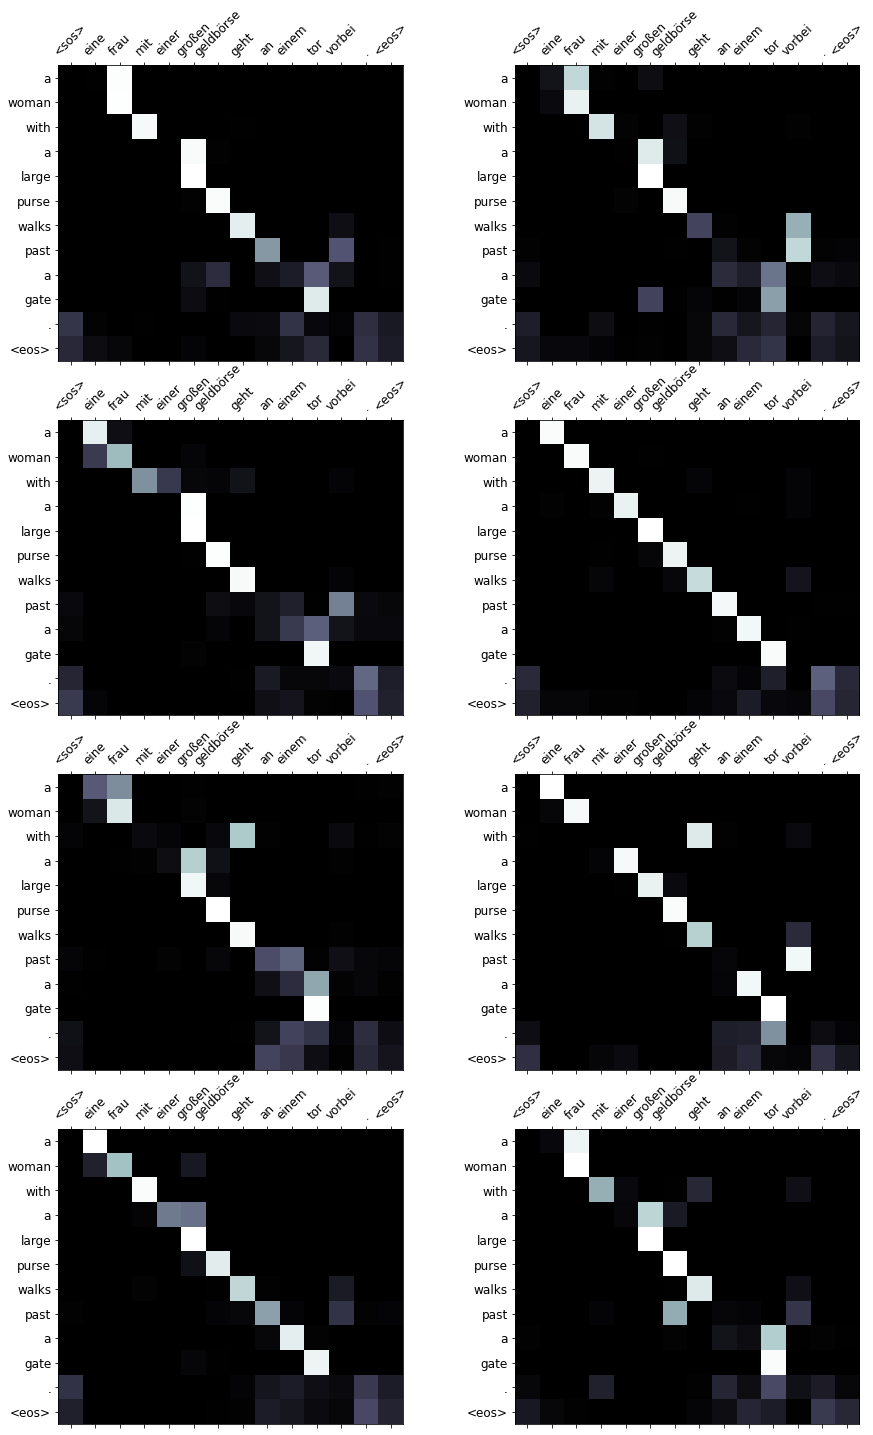

In [59]:
display_attention(src, translation, attention)

In [60]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [61]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'running', 'after', 'a', 'black', 'dog', '.', '<eos>']


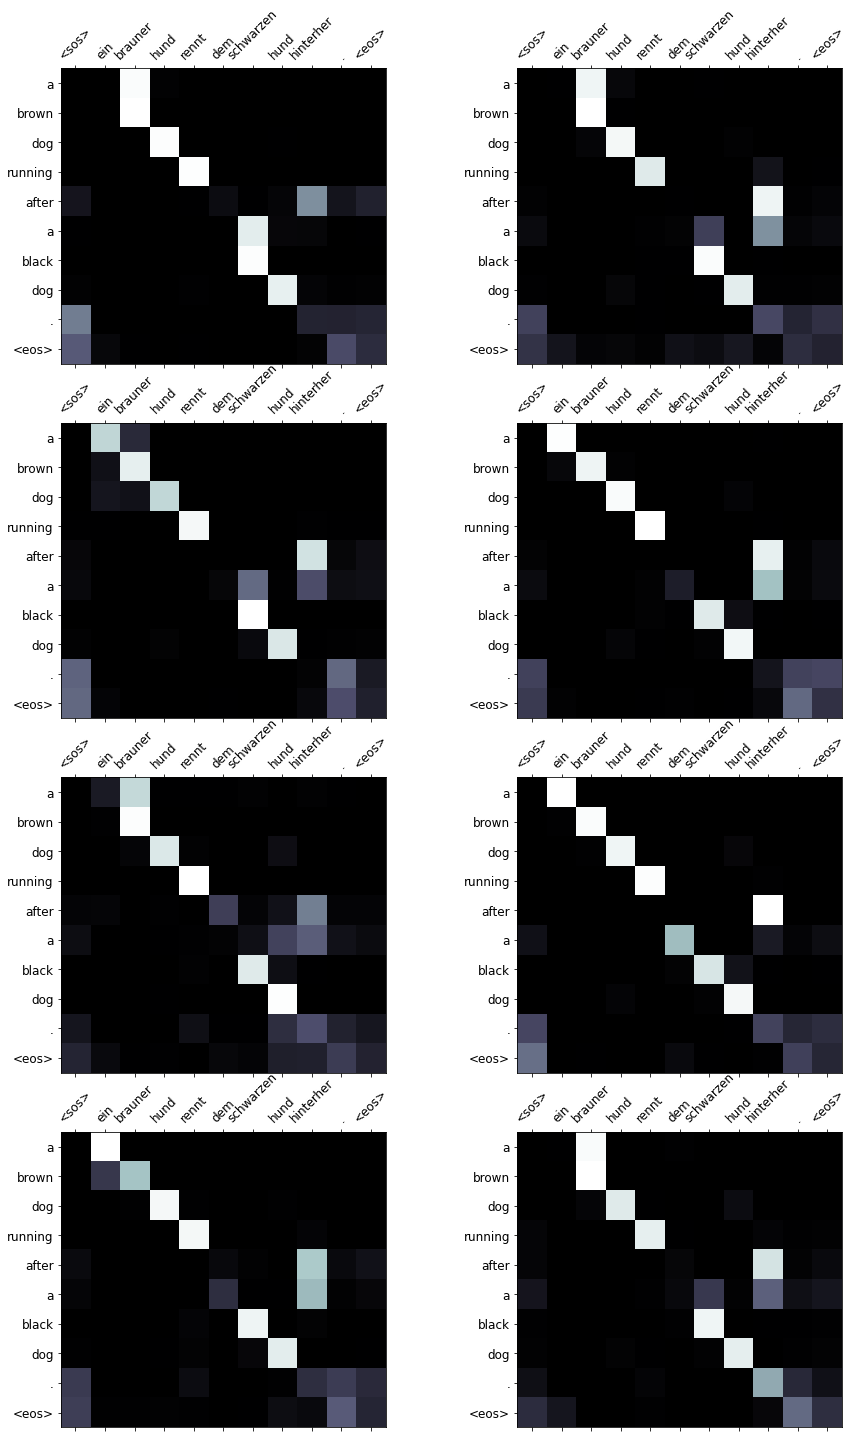

In [62]:
display_attention(src, translation, attention)

## BLEU

In [63]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [64]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 35.38
